Link to presentation -> https://www.canva.com/design/DAGlRi2aRag/JIKGr9Ugv8PilGWcy597Ew/edit

# Part 1 -Data gathering and Initial Analysis
This notebook focuses on examining the raw dataset containing daily historical prices of Ashok Leyland stocks. The goal is to identify a specific timeframe suitable for further analysis and prediction.

> **INPUT**: The raw data file of all available stock prices of Ashok Leyland, as downloaded from its original source. <br/>
> **OUTPUT**: The extracted historical data of the targeted period for analysis, stored in an intermediary location for next steps.

## 1. INITIALIZATION

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fc7304d3e9acba6ea0831b05d42d30ddf3789335e62984e3cb55eb0c7c06df3b
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from datetime import timedelta

## 2. LOAD DATASET FILE

The dataset we are going to initially load and explore is the historical records of daily price details of Ashok Leyland sourced from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG).

At first, we load the complete dataset available spanning a period from 2004-08-19 up until the time of creating this script.

The main objective of loading the entire dataset is to choose a particular time frame for analysis.

### Downloading Dataset

[Date , open , Close , Adj_Close , Volume ,Low , High]

In [ ]:
# Define the ticker symbol (for NSE)
ticker_symbol = "ASHOKLEY.NS"
end_date =  pd.Timestamp.today()
start_date = end_date - timedelta(days=5*365)  # Approximate 5 years

# Fetch data from Yahoo Finance, including 'Adj Close'
data = yf.download(ticker_symbol, start=start_date.strftime('%Y-%m-%d'), auto_adjust=False)

# Define file path to save the data
data_file_location = "/content/data/"
os.makedirs(data_file_location, exist_ok=True)

data_file_name = "AshokLeyLand"
data_file_ext = "csv"
file_path = f"{data_file_location}{data_file_name}.{data_file_ext}"

# Save the downloaded data to CSV
data.reset_index(inplace=True)
data.to_csv(file_path, index=False)

# Now, read the data from the saved CSV file
data = pd.read_csv(file_path , skiprows = [1])
data["Date"] = pd.to_datetime(data["Date"])
# Rename columns to a simpler format
data.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)

# Convert 'Date' column to datetime objects (if needed)
data["Date"] = pd.to_datetime(data["Date"])

# Save the cleaned data back
data.to_csv(file_path, index=False)

# Display first few rows
print(data.head())

[*********************100%***********************]  1 of 1 completed


        Date  Adj_Close      Close       High        Low       Open    Volume
0 2020-04-24  41.442223  44.950001  46.299999  44.599998  46.000000  15044148
1 2020-04-27  40.842953  44.299999  46.200001  43.900002  45.700001  20228019
2 2020-04-28  41.073437  44.549999  45.500000  43.750000  45.200001  18534474
3 2020-04-29  44.208115  47.950001  48.750000  44.549999  45.150002  42144085
4 2020-04-30  48.264751  52.349998  53.200001  49.099998  49.099998  56358089


### Adding Addition fundamental and Technical details

In [ ]:
# Adding P/E ratio, Sector, Industry info
stock = yf.Ticker(ticker_symbol)
sector = stock.info.get("sector", "N/A")  # Sector
industry = stock.info.get("industry", "N/A")  # Industry
pe_ratio = stock.info.get("trailingPE", "N/A")  # P/E Ratio
print(f"Sector: {sector}, Industry: {industry}, P/E Ratio: {pe_ratio}")

# Extract date range from existing data
earliest_date = data["Date"].min()
latest_date = data["Date"].max()

# Get global market data (extend date range to account for time zone differences)
extended_start_date = (earliest_date - pd.Timedelta(days=10)).strftime('%Y-%m-%d')
end_date = latest_date.strftime('%Y-%m-%d')

# Function to get global market data - with safer error handling
def get_global_market_data(start_date, end_date):
    # Dictionary of market indices to track
    market_indices = {
        'US_SP500': '^GSPC',       # S&P 500 (US)
        'US_NASDAQ': '^IXIC',      # NASDAQ (US)
        'US_DOW': '^DJI',          # Dow Jones (US)
        'UK_FTSE': '^FTSE',        # FTSE 100 (UK)
        'JP_NIKKEI': '^N225',      # Nikkei 225 (Japan)
        'HK_HANGSENG': '^HSI',     # Hang Seng (Hong Kong)
        'CN_SHANGHAI': '000001.SS', # Shanghai Composite (China)
        'EU_STOXX50': '^STOXX50E', # Euro STOXX 50 (Europe)
        'KR_KOSPI': '^KS11',       # KOSPI (South Korea)
        'SG_STI': '^STI'           # Straits Times Index (Singapore)
    }

    global_data = {}
    for market, ticker in market_indices.items():
        try:
            market_data = yf.download(ticker, start=start_date, end=end_date)
            if not market_data.empty and 'Adj Close' in market_data.columns:
                # Calculate daily returns with proper error handling
                market_data['Return'] = market_data['Adj Close'].pct_change()
                global_data[market] = market_data
                print(f"Successfully downloaded data for {market}")
            else:
                print(f"No data or missing columns for {market}")
        except Exception as e:
            print(f"Error downloading {market} data: {e}")

    return global_data

# Download global market data
global_markets = get_global_market_data(extended_start_date, end_date)

Sector: Industrials, Industry: Farm & Heavy Construction Machinery, P/E Ratio: 23.39917
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


No data or missing columns for US_SP500


[*********************100%***********************]  1 of 1 completed


No data or missing columns for US_NASDAQ


[*********************100%***********************]  1 of 1 completed


No data or missing columns for US_DOW


[*********************100%***********************]  1 of 1 completed


No data or missing columns for UK_FTSE


[*********************100%***********************]  1 of 1 completed


No data or missing columns for JP_NIKKEI


[*********************100%***********************]  1 of 1 completed


No data or missing columns for HK_HANGSENG


[*********************100%***********************]  1 of 1 completed


No data or missing columns for CN_SHANGHAI


[*********************100%***********************]  1 of 1 completed


No data or missing columns for EU_STOXX50


[*********************100%***********************]  1 of 1 completed


No data or missing columns for KR_KOSPI


[*********************100%***********************]  1 of 1 completed

No data or missing columns for SG_STI


In [ ]:
# Download global market data
global_markets = {}
global_indices = {
    'US_SP500': '^GSPC',
    'US_NASDAQ': '^IXIC',
    'US_DOW': '^DJI',
    'JP_NIKKEI': '^N225',
    'HK_HANGSENG': '^HSI',
    'CN_SHANGHAI': '000001.SS',
    'KR_KOSPI': '^KS11',
    'SG_STI': '^STI',
    'EU_STOXX50': '^STOXX50E',
    'UK_FTSE': '^FTSE',
    'DE_DAX': '^GDAXI',
    'FR_CAC': '^FCHI'
}

for market_name, ticker in global_indices.items():
    try:
        print(f"Downloading data for {market_name}: {ticker}")
        market_data = yf.download(ticker, start=extended_start_date, end=end_date)
        if not market_data.empty and 'Adj Close' in market_data.columns:
            market_data['Return'] = market_data['Adj Close'].pct_change()
            global_markets[market_name] = market_data
        else:
            print(f"No data found for {market_name}")
    except Exception as e:
        print(f"Error downloading {market_name} data: {e}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

No data found for US_SP500
No data found for US_NASDAQ



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No data found for US_DOW
No data found for JP_NIKKEI
No data found for HK_HANGSENG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No data found for CN_SHANGHAI
No data found for KR_KOSPI
No data found for SG_STI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


No data found for EU_STOXX50
No data found for UK_FTSE


[*********************100%***********************]  1 of 1 completed


No data found for DE_DAX


[*********************100%***********************]  1 of 1 completed

No data found for FR_CAC


In [ ]:


# Calculate Moving Averages
data["20MA"] = data["Adj_Close"].rolling(window=20).mean()  # 20-day SMA
data["50MA"] = data["Adj_Close"].rolling(window=50).mean()  # 50-day SMA
data["200MA"] = data["Adj_Close"].rolling(window=200).mean()  # 200-day SMA

# Calculate EMA
data["EMA"] = data["Adj_Close"].ewm(span=20, adjust=False).mean()  # 20-day EMA
data["50EMA"] = data["Adj_Close"].ewm(span=50, adjust=False).mean()  # 50-day EMA
data["200EMA"] = data["Adj_Close"].ewm(span=200, adjust=False).mean()  # 200-day EMA

# Calculate additional technical indicators
# MACD
macd = ta.trend.MACD(data['Adj_Close'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Hist'] = macd.macd_diff()

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Adj_Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()
data['BB_Mid'] = bollinger.bollinger_mavg()
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['BB_Mid']
data['Dist_From_Upper_Band'] = (data['BB_High'] - data['Adj_Close']) / data['BB_High']
data['Dist_From_Lower_Band'] = (data['Adj_Close'] - data['BB_Low']) / data['Adj_Close']

# Volume indicators
data['OBV'] = ta.volume.OnBalanceVolumeIndicator(data['Adj_Close'], data['Volume']).on_balance_volume()
data['Volume_MA10'] = data['Volume'].rolling(window=10).mean()
data['Volume_Ratio'] = data['Volume'] / data['Volume_MA10']

# RSI and other momentum indicators
data['RSI_14'] = ta.momentum.RSIIndicator(data['Adj_Close'], window=14).rsi()
data['RSI_7'] = ta.momentum.RSIIndicator(data['Adj_Close'], window=7).rsi()
data['Stoch_RSI'] = ta.momentum.StochRSIIndicator(data['Adj_Close']).stochrsi_k()
data['Williams_R'] = ta.momentum.WilliamsRIndicator(data['High'], data['Low'], data['Adj_Close']).williams_r()

# ADX - Trend strength
adx_indicator = ta.trend.ADXIndicator(data['High'], data['Low'], data['Adj_Close'])
data['ADX'] = adx_indicator.adx()
data['DI_pos'] = adx_indicator.adx_pos()
data['DI_neg'] = adx_indicator.adx_neg()

# Ichimoku Cloud
ichimoku = ta.trend.IchimokuIndicator(data['High'], data['Low'])
data['Ichimoku_A'] = ichimoku.ichimoku_a()
data['Ichimoku_B'] = ichimoku.ichimoku_b()
data['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
data['Ichimoku_Conv'] = ichimoku.ichimoku_conversion_line()

# Price change and returns
data['Daily_Return'] = data['Adj_Close'].pct_change()
data['Log_Return'] = np.log(data['Adj_Close'] / data['Adj_Close'].shift(1))
data['5D_Return'] = data['Adj_Close'].pct_change(5)
data['10D_Return'] = data['Adj_Close'].pct_change(10)

# Lag features
data['Close_Lag1'] = data['Adj_Close'].shift(1)
data['Close_Lag2'] = data['Adj_Close'].shift(2)
data['Close_Lag3'] = data['Adj_Close'].shift(3)
data['Close_Lag5'] = data['Adj_Close'].shift(5)

# Cyclical features
data['Day_of_Week'] = data["Date"].dt.dayofweek  # Extract day of the week (0 = Monday, 6 = Sunday)
data['Month'] = data["Date"].dt.month
data['Day_of_Month'] = data["Date"].dt.day
data['Quarter'] = data["Date"].dt.quarter

# Feature for monthly volatility
data['Monthly_Volatility'] = data.groupby(data['Date'].dt.to_period('M'))['Daily_Return'].transform(lambda x: x.std())

# Create MA crossover signals
data['MA_20_50_Cross'] = np.where(data['20MA'] > data['50MA'], 1, -1)
data['MA_50_200_Cross'] = np.where(data['50MA'] > data['200MA'], 1, -1)
data['EMA_20_50_Cross'] = np.where(data['EMA'] > data['50EMA'], 1, -1)

# Create combined signal based on ALL moving averages
data['MA_Signal'] = np.where(
    (data['Adj_Close'] > data['20MA']) &
    (data['Adj_Close'] > data['50MA']) &
    (data['Adj_Close'] > data['200MA']) &
    (data['Adj_Close'] > data['EMA']) &
    (data['Adj_Close'] > data['50EMA']) &
    (data['Adj_Close'] > data['200EMA']),
    1, # Strong bullish - price above all MAs
    np.where(
        (data['Adj_Close'] < data['20MA']) &
        (data['Adj_Close'] < data['50MA']) &
        (data['Adj_Close'] < data['200MA']) &
        (data['Adj_Close'] < data['EMA']) &
        (data['Adj_Close'] < data['50EMA']) &
        (data['Adj_Close'] < data['200EMA']),
        -1, # Strong bearish - price below all MAs
        0 # Mixed signals
    )
)

# Price position relative to MA bands
data['Price_to_MA_20'] = data['Adj_Close'] / data['20MA'] - 1
data['Price_to_MA_50'] = data['Adj_Close'] / data['50MA'] - 1
data['Price_to_MA_200'] = data['Adj_Close'] / data['200MA'] - 1

# Trend strength indicator based on MA alignments
data['Trend_Strength'] = (
    (data['20MA'] > data['50MA']).astype(int) +
    (data['50MA'] > data['200MA']).astype(int) +
    (data['EMA'] > data['50EMA']).astype(int) +
    (data['50EMA'] > data['200EMA']).astype(int)
) - 2  # Scale from -2 to 2

# Safely add India-specific market indicators
try:
    # Download Indian market data
    nifty50 = yf.download('^NSEI', start=extended_start_date, end=end_date)
    if not nifty50.empty and 'Adj Close' in nifty50.columns:
        nifty50['Return'] = nifty50['Adj Close'].pct_change()

        # Safely add nifty data to our main dataframe
        data['Nifty_Return'] = np.nan  # Initialize with NaN
        for idx, row in data.iterrows():
            current_date = row['Date']
            # Find matching dates in Nifty data
            matching_nifty = nifty50[nifty50.index.date == current_date.date()]
            if not matching_nifty.empty and 'Return' in matching_nifty.columns:
                data.loc[idx, 'Nifty_Return'] = matching_nifty['Return'].iloc[0]

        # Calculate Nifty correlations if we have the data
        if 'Nifty_Return' in data.columns:
            data['Nifty_Correlation'] = data['Daily_Return'].rolling(30).corr(data['Nifty_Return'])

            # Calculate Beta safely
            nifty_var = data['Nifty_Return'].rolling(30).var()
            cov_with_nifty = data['Daily_Return'].rolling(30).cov(data['Nifty_Return'])
            data['Beta_Nifty'] = np.where(nifty_var > 0, cov_with_nifty / nifty_var, np.nan)

            # Relative strength
            data['Relative_Strength_Nifty'] = data['Daily_Return'] - data['Nifty_Return']
            data['Cumulative_RS_Nifty'] = data['Relative_Strength_Nifty'].rolling(10).sum()

    # Similarly download Sensex data with proper error handling
    try:
        sensex = yf.download('^BSESN', start=extended_start_date, end=end_date)
        if not sensex.empty and 'Adj Close' in sensex.columns:
            sensex['Return'] = sensex['Adj Close'].pct_change()

            # Add Sensex returns
            data['Sensex_Return'] = np.nan
            for idx, row in data.iterrows():
                current_date = row['Date']
                matching_sensex = sensex[sensex.index.date == current_date.date()]
                if not matching_sensex.empty and 'Return' in matching_sensex.columns:
                    data.loc[idx, 'Sensex_Return'] = matching_sensex['Return'].iloc[0]

            # Sensex correlations
            if 'Sensex_Return' in data.columns:
                data['Sensex_Correlation'] = data['Daily_Return'].rolling(30).corr(data['Sensex_Return'])
    except Exception as e:
        print(f"Error processing Sensex data: {e}")

    # Add India VIX with error handling
    try:
        india_vix = yf.download('^INDIAVIX', start=extended_start_date, end=end_date)
        if not india_vix.empty and 'Close' in india_vix.columns:
            india_vix['Change'] = india_vix['Close'].pct_change()

            # Add VIX data
            data['VIX_Change'] = np.nan
            for idx, row in data.iterrows():
                current_date = row['Date']
                matching_vix = india_vix[india_vix.index.date == current_date.date()]
                if not matching_vix.empty and 'Change' in matching_vix.columns:
                    data.loc[idx, 'VIX_Change'] = matching_vix['Change'].iloc[0]

            # VIX correlations
            if 'VIX_Change' in data.columns:
                data['Return_VIX_Correlation'] = data['Daily_Return'].rolling(20).corr(data['VIX_Change'])
    except Exception as e:
        print(f"Error processing India VIX data: {e}")
except Exception as e:
    print(f"Error processing Indian market data: {e}")

# Add global market influence features
# Function to align dates across different time zones with safer implementation
def add_global_market_features(data, global_markets):
    # For each global market, add its influence features
    for market_name, market_data in global_markets.items():
        if market_data.empty or 'Return' not in market_data.columns:
            continue

        # Determine feature name based on market region
        if any(us_market in market_name for us_market in ['US_SP500', 'US_NASDAQ', 'US_DOW']):
            feature_name = f'{market_name}_Prev_Return'
            is_previous_day = True
        elif any(asian_market in market_name for asian_market in ['JP_NIKKEI', 'HK_HANGSENG', 'CN_SHANGHAI', 'KR_KOSPI', 'SG_STI']):
            feature_name = f'{market_name}_Same_Return'
            is_previous_day = False
        else:  # European markets
            feature_name = f'{market_name}_Prev_Return'
            is_previous_day = True

        # Initialize the feature column
        data[feature_name] = np.nan

        # For each date in our main data, find the appropriate global market data
        for idx, row in data.iterrows():
            current_date = row['Date']

            if is_previous_day:
                # Get the previous trading day's data
                prev_day_data = market_data[market_data.index < current_date]
                if not prev_day_data.empty:
                    data.loc[idx, feature_name] = prev_day_data['Return'].iloc[-1]
            else:
                # Get the same day's data
                same_day_data = market_data[market_data.index.date == current_date.date()]
                if not same_day_data.empty:
                    data.loc[idx, feature_name] = same_day_data['Return'].iloc[0]

    # Add global market sentiment counts - only count columns that actually exist
    global_return_cols = [col for col in data.columns if ('_Return' in col and col != 'Daily_Return')]
    if global_return_cols:
        data['Global_Positive_Count'] = data[global_return_cols].gt(0).sum(axis=1)
        data['Global_Negative_Count'] = data[global_return_cols].lt(0).sum(axis=1)
        data['Global_Sentiment'] = data['Global_Positive_Count'] - data['Global_Negative_Count']

    # Calculate correlations with US markets if available
    us_cols = [col for col in data.columns if 'US_' in col and '_Return' in col]
    for us_col in us_cols:
        correlation_col = f'{us_col.split("_Prev")[0]}_Correlation'
        data[correlation_col] = data['Daily_Return'].rolling(30).corr(data[us_col])

    return data

# Add global market features
data = add_global_market_features(data, global_markets)

# Add sector-specific ETF or index performance if available and the sector is known
if sector != "N/A":
    sector_etf_mapping = {
        "Information Technology": "NIFTIT.NS",
        "Financial Services": "NIFTYFIN.NS",  # Simplified ticker
        "Energy": "NIFTYENERGY.NS",  # Simplified ticker
        "Healthcare": "NIFTYPHARMA.NS",
        "Consumer Goods": "NIFTYFMCG.NS",
        "Automobile": "NIFTYAUTO.NS",
        "Metal": "NIFTYMETAL.NS",
        # Add more sector mappings as needed
    }

    if sector in sector_etf_mapping:
        try:
            ticker = sector_etf_mapping[sector]
            print(f"Attempting to download sector data for {sector} using ticker {ticker}")
            sector_data = yf.download(ticker, start=extended_start_date, end=end_date)

            if not sector_data.empty and 'Adj Close' in sector_data.columns:
                sector_data['Return'] = sector_data['Adj Close'].pct_change()

                # Add sector returns with date matching
                data['Sector_Return'] = np.nan
                for idx, row in data.iterrows():
                    current_date = row['Date']
                    matching_sector = sector_data[sector_data.index.date == current_date.date()]
                    if not matching_sector.empty and 'Return' in matching_sector.columns:
                        data.loc[idx, 'Sector_Return'] = matching_sector['Return'].iloc[0]

                # Calculate sector relationships if we have the data
                if 'Sector_Return' in data.columns:
                    data['Sector_Relative_Strength'] = data['Daily_Return'] - data['Sector_Return']

                    # Calculate sector beta safely
                    sector_var = data['Sector_Return'].rolling(30).var()
                    cov_with_sector = data['Daily_Return'].rolling(30).cov(data['Sector_Return'])
                    data['Sector_Beta'] = np.where(sector_var > 0, cov_with_sector / sector_var, np.nan)
            else:
                print(f"No data found for sector {sector} with ticker {ticker}")
        except Exception as e:
            print(f"Error processing sector data for {sector}: {e}")

# Add USD/INR exchange rate effects safely
try:
    usdinr = yf.download("INR=X", start=extended_start_date, end=end_date)
    if not usdinr.empty and 'Adj Close' in usdinr.columns:
        usdinr['Return'] = usdinr['Adj Close'].pct_change()

        # Add exchange rate data with date matching
        data['USDINR_Change'] = np.nan
        for idx, row in data.iterrows():
            current_date = row['Date']
            matching_fx = usdinr[usdinr.index.date == current_date.date()]
            if not matching_fx.empty and 'Return' in matching_fx.columns:
                data.loc[idx, 'USDINR_Change'] = matching_fx['Return'].iloc[0]

        # Calculate correlation if we have the data
        if 'USDINR_Change' in data.columns:
            data['Stock_Currency_Corr'] = data['Daily_Return'].rolling(20).corr(data['USDINR_Change'])
except Exception as e:
    print(f"Error processing USD/INR data: {e}")

# International lead-lag effects indicator
if 'Global_Sentiment' in data.columns:
    data['Global_Lead'] = data['Global_Sentiment'].shift(1)
    data['Global_Signal'] = np.where(data['Global_Lead'] > 0, 1, np.where(data['Global_Lead'] < 0, -1, 0))

# Combine all MA indicators into a single trend strength feature
data['MA_Combined_Signal'] = (
    (data['MA_20_50_Cross'] +
     data['MA_50_200_Cross'] +
     data['EMA_20_50_Cross'] +
     data['MA_Signal']
    ) / 4
)

# Fill NaN values
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(method="bfill")
# For any remaining NAs
data[numeric_columns] = data[numeric_columns].fillna(0)

# Reset index to include 'Date'
data.reset_index(inplace=True, drop=True)

# Display sample data and column list
print("\nColumns in the dataset:")
print(data.columns.tolist())
print("\nSample data:")
print(data.head())

# Print feature importance note
print("\nNote: After training your model, check feature importance to identify which global markets have the strongest influence on your stock.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^INDIAVIX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-04-14 -> 2025-04-23)')
[*********************100%***********************]  1 of 1 completed


Columns in the dataset:
['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', '20MA', '50MA', '200MA', 'EMA', '50EMA', '200EMA', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_High', 'BB_Low', 'BB_Mid', 'BB_Width', 'Dist_From_Upper_Band', 'Dist_From_Lower_Band', 'OBV', 'Volume_MA10', 'Volume_Ratio', 'RSI_14', 'RSI_7', 'Stoch_RSI', 'Williams_R', 'ADX', 'DI_pos', 'DI_neg', 'Ichimoku_A', 'Ichimoku_B', 'Ichimoku_Base', 'Ichimoku_Conv', 'Daily_Return', 'Log_Return', '5D_Return', '10D_Return', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3', 'Close_Lag5', 'Day_of_Week', 'Month', 'Day_of_Month', 'Quarter', 'Monthly_Volatility', 'MA_20_50_Cross', 'MA_50_200_Cross', 'EMA_20_50_Cross', 'MA_Signal', 'Price_to_MA_20', 'Price_to_MA_50', 'Price_to_MA_200', 'Trend_Strength', 'Global_Positive_Count', 'Global_Negative_Count', 'Global_Sentiment', 'Global_Lead', 'Global_Signal', 'MA_Combined_Signal']

Sample data:
        Date  Adj_Close      Close       High        Low       Open    Volume  \
0 2020-04-24 


<ipython-input-6-56c667ffb56f>:316: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[numeric_columns] = data[numeric_columns].fillna(method="bfill")


In [ ]:
# Check dataset shape
data.shape

(1238, 63)

In [ ]:
# Check dataset head
data.tail()

,Date,Adj_Close,Close,High,Low,Open,Volume,20MA,50MA,200MA,...,Price_to_MA_20,Price_to_MA_50,Price_to_MA_200,Trend_Strength,Global_Positive_Count,Global_Negative_Count,Global_Sentiment,Global_Lead,Global_Signal,MA_Combined_Signal
1233,2025-04-16,214.399994,214.399994,215.500000,212.869995,214.699997,4834906,207.303500,210.694201,224.414008,...,0.034232,0.017588,-0.044623,-2,2,1,1,3.0,1,-0.75
1234,2025-04-17,218.979996,218.979996,219.399994,212.830002,214.289993,6372845,208.329499,210.737201,224.309103,...,0.051123,0.039114,-0.023758,-2,3,0,3,1.0,1,-0.75
1235,2025-04-21,222.059998,222.059998,223.100006,218.160004,219.440002,5302390,209.509499,211.051400,224.220936,...,0.059904,0.052161,-0.009638,-2,3,0,3,3.0,1,-0.75
1236,2025-04-22,222.669998,222.669998,225.339996,220.910004,222.000000,5057422,210.358498,211.426600,224.151227,...,0.058526,0.053179,-0.006608,-1,3,0,3,3.0,1,-0.25
1237,2025-04-23,225.100006,225.100006,228.279999,223.000000,224.000000,4603212,211.239499,211.695201,224.114775,...,0.065615,0.063321,0.004396,-1,3,0,3,3.0,1,0.00


## 3. INITIAL DATA CLEANING

As we notice, the Date column is currently in a String format which requires conversion to proper Datetime format.

In [ ]:
# Check column format
data.dtypes

,0
Date,datetime64[ns]
Adj_Close,float64
Close,float64
High,float64
Low,float64
...,...
Global_Negative_Count,int64
Global_Sentiment,int64
Global_Lead,float64
Global_Signal,int64


## 4. EXPLORE DATASET

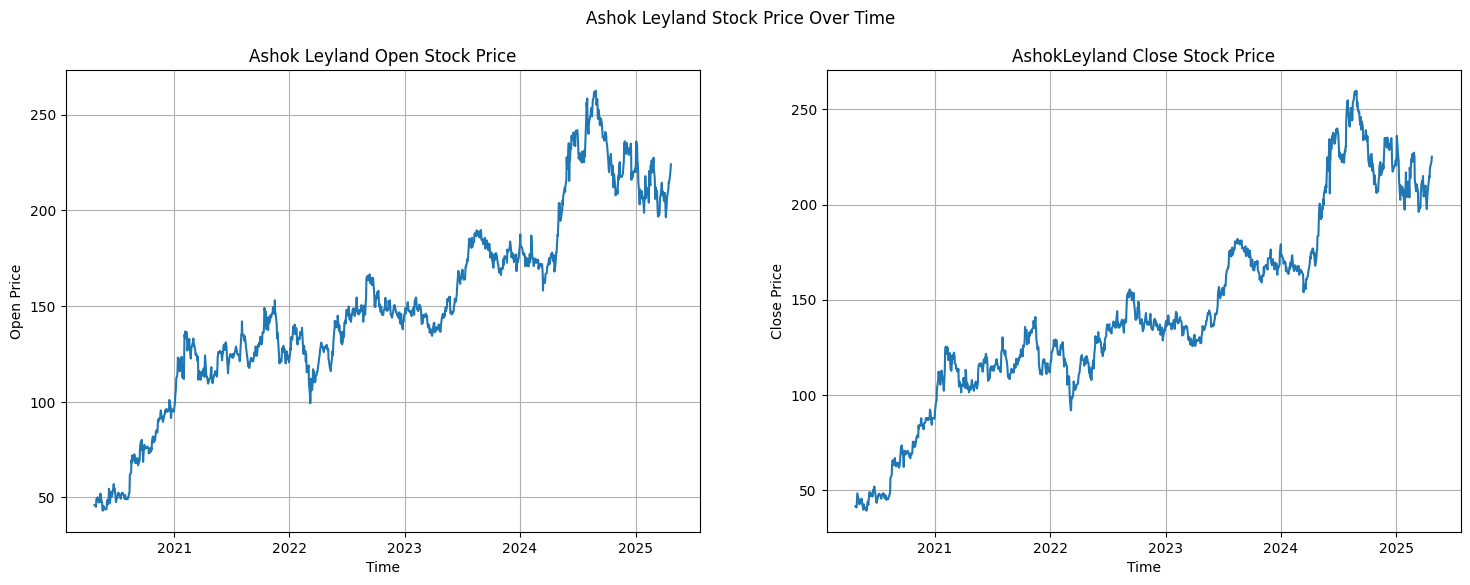

In [ ]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price")
plt.title("Ashok Leyland Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Adj_Close"])
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("AshokLeyland Close Stock Price")
plt.grid()

plt.suptitle("Ashok Leyland Stock Price Over Time")
plt.show()

The previous charts show an inconsistent behavior in the stock's performance over time, with a completely distinct trend during the past five years.

This means that the old historical data might not be relevant to the predictions, since it's most likely to represents a different period with outdated indicators that don't affect the current trend.

Accordingly, we will concentrate our analysis on the most recent five-year data, as it is expected to provide more accurate insights for predicting future trends.

In [ ]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= start_date.year]

# Check filtered data shape
data_5years.shape

(1238, 63)

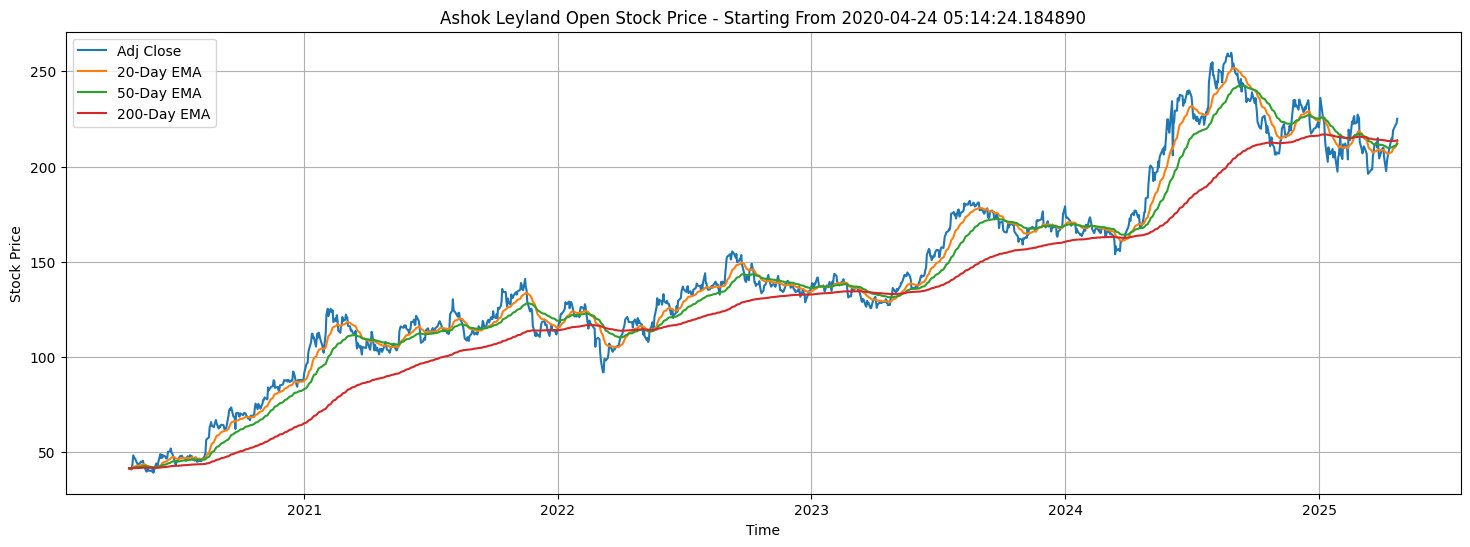

In [ ]:
# Plot Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data['Date'], data['Adj_Close'], label='Adj Close')
plt.plot(data['Date'], data['EMA'],    label='20‑Day EMA')
plt.plot(data['Date'], data['50EMA'],  label='50‑Day EMA')
plt.plot(data['Date'], data['200EMA'], label='200‑Day EMA')
# plt.plot(data['Date'], data['20MA'],    label='20‑Day MA')
# plt.plot(data['Date'], data['50MA'],  label='50‑Day MA')
# plt.plot(data['Date'], data['200MA'], label='200‑Day MA')

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title(f"Ashok Leyland Open Stock Price - Starting From {start_date}")
plt.legend()
plt.grid()

### Plotting MACD

*A trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price, helping to identify potential buy or sell signals.*

#### MACD Indicators
* MACD: Difference between 12EMA and 26EMA, used for trend strength.

* MACD_Signal: 9-day EMA of MACD, used to generate buy/sell signals.

* MACD_Hist: MACD - Signal line, shows convergence/divergence.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go



def plot_macd(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['MACD'], label='MACD')
    plt.plot(df['Date'], df['MACD_Signal'], label='Signal Line')
    plt.bar(df['Date'], df['MACD_Hist'], label='Histogram', color='gray')
    plt.title('MACD Indicator')
    plt.xlabel('Date')
    plt.ylabel('MACD Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

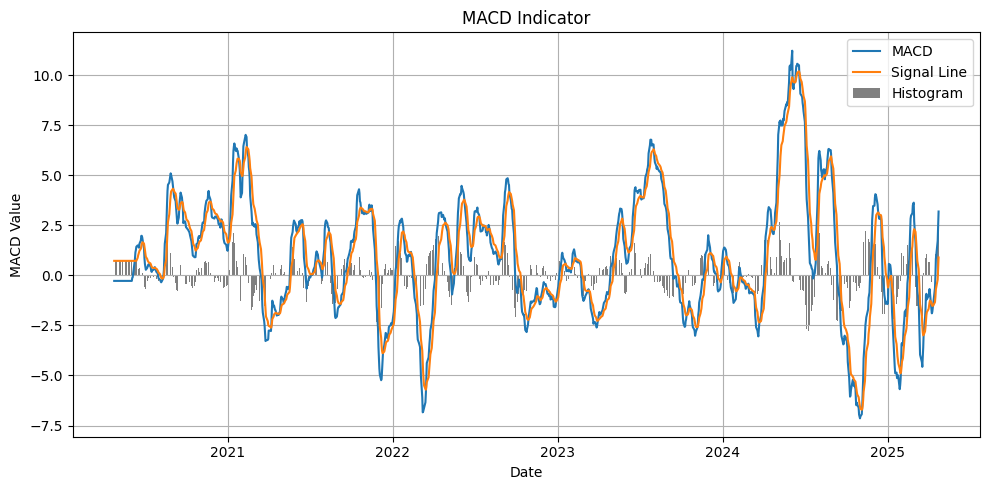

In [ ]:
plot_macd(data)

### RSI Plot

*Above 70: Potentially overbought (may indicate a sell signal).
Below 30: Potentially oversold (may indicate a buy signal).*

In [ ]:
def plot_rsi(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['RSI_14'], label='RSI (14)')
    plt.axhline(70, color='red', linestyle='--', label='Overbought')
    plt.axhline(30, color='green', linestyle='--', label='Oversold')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

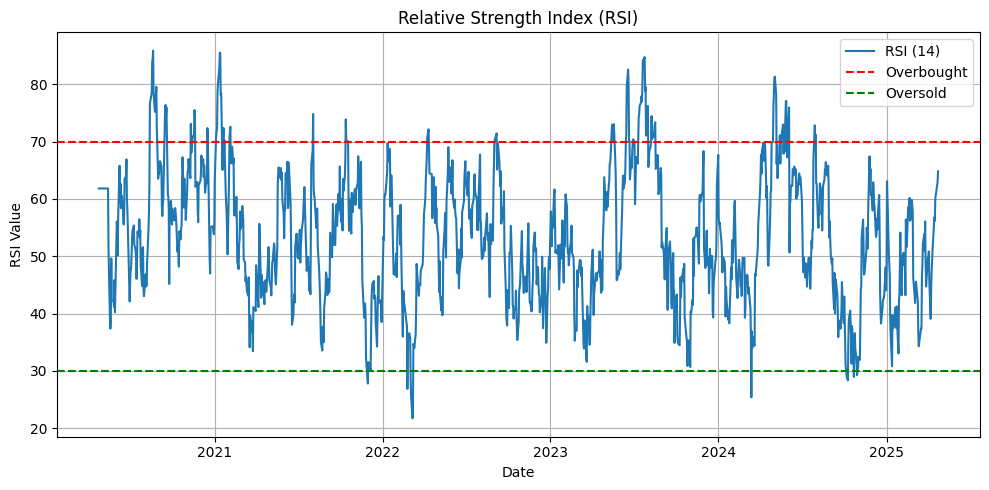

In [ ]:
plot_rsi(data)

### Bollinger Bands

A volatility indicator that consists of three lines:

1. Middle Band: A simple moving average.

2. Upper Band: Middle band + 2 standard deviations.

3. Lower Band: Middle band – 2 standard deviations.

🔍 Purpose:
Helps identify overbought/oversold conditions, price volatility, and potential breakouts.

In [ ]:

def plot_bollinger_bands(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price', color='black')
    plt.plot(df['Date'], df['BB_High'], label='Upper Band', linestyle='--', color='red')
    plt.plot(df['Date'], df['BB_Low'], label='Lower Band', linestyle='--', color='green')
    plt.plot(df['Date'], df['BB_Mid'], label='Middle Band', linestyle='--', color='blue')
    plt.fill_between(df['Date'], df['BB_Low'], df['BB_High'], color='lightgray', alpha=0.3)
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


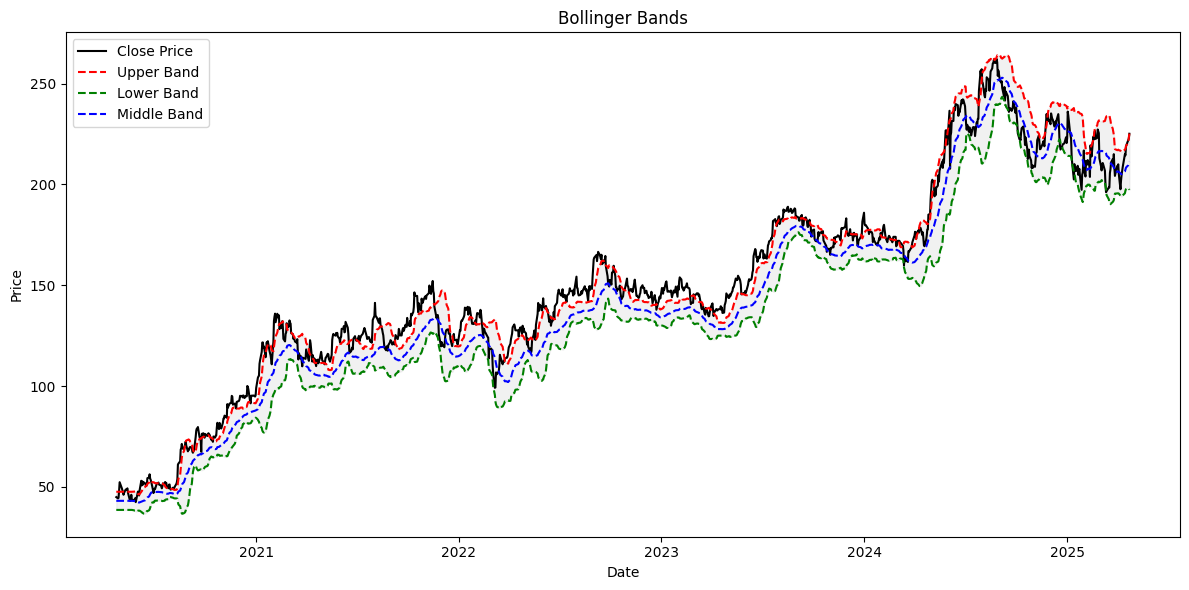

In [ ]:
plot_bollinger_bands(data)

### ADX and DI
📈 ADX (Average Directional Index):
Measures the strength of a trend (but not the direction).

* Range: 0–100

* Above 25: Strong trend

* Below 20: Weak or no trend

🔀 DI+ and DI− (Directional Indicators):
* DI+ (Positive Directional Indicator): Measures upward movement.

* DI− (Negative Directional Indicator): Measures downward movement.

When DI+ > DI−, uptrend is dominant;
when DI− > DI+, downtrend is dominant.

In [ ]:
def plot_adx_di(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['ADX'], label='ADX')
    plt.plot(df['Date'], df['DI_pos'], label='+DI')
    plt.plot(df['Date'], df['DI_neg'], label='-DI')
    plt.title('ADX and Directional Indicators')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


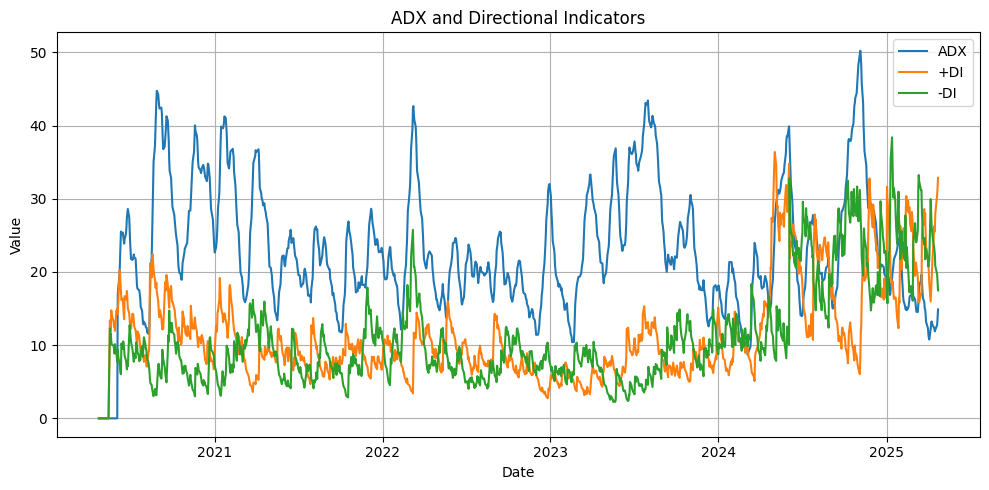

In [ ]:
plot_adx_di(data)

In [ ]:
def plot_candlestick(df):
    fig = go.Figure(data=[go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        increasing_line_color='green', decreasing_line_color='red'
    )])
    fig.update_layout(title='Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
    fig.show()


In [ ]:
plot_candlestick(data)


In [ ]:
def plot_volume_vs_price(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Primary axis for Closing Price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='green')
    ax1.plot(df['Date'], df['Close'], color='green', label='Close Price')
    ax1.tick_params(axis='y', labelcolor='green')

    # Secondary axis for Volume
    ax2 = ax1.twinx()
    ax2.set_ylabel('Volume', color='gray')
    ax2.bar(df['Date'], df['Volume'], alpha=0.4, color='gray', label='Volume')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Title and layout
    plt.title('Close Price vs Volume')
    fig.tight_layout()
    plt.show()


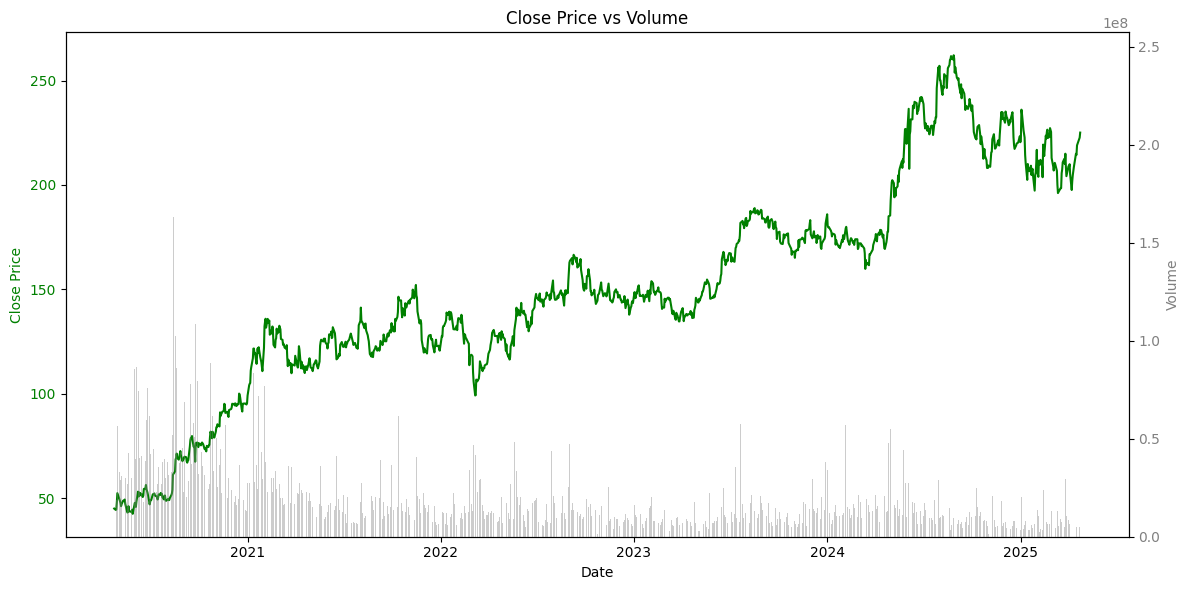

In [ ]:

plot_volume_vs_price(data)

In [ ]:
def plot_sentiment(df):
    # Convert 'Date' to datetime if not already
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter last 3 years
    cutoff = df['Date'].max() - pd.DateOffset(years=2)
    df_recent = df[df['Date'] >= cutoff].copy()

    # Rolling average to smooth
    df_recent['Pos_Smooth'] = df_recent['Global_Positive_Count'].rolling(window=5).mean()
    df_recent['Neg_Smooth'] = df_recent['Global_Negative_Count'].rolling(window=5).mean()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df_recent['Date'], df_recent['Pos_Smooth'], label='Positive News (Smoothed)', color='green', linewidth=2)
    plt.plot(df_recent['Date'], df_recent['Neg_Smooth'], label='Negative News (Smoothed)', color='red', linewidth=2)

    plt.fill_between(df_recent['Date'], df_recent['Pos_Smooth'], df_recent['Neg_Smooth'],
                     where=(df_recent['Pos_Smooth'] > df_recent['Neg_Smooth']),
                     color='green', alpha=0.1)

    plt.fill_between(df_recent['Date'], df_recent['Neg_Smooth'], df_recent['Pos_Smooth'],
                     where=(df_recent['Neg_Smooth'] > df_recent['Pos_Smooth']),
                     color='red', alpha=0.1)

    plt.title('Global Sentiment (Last 2 Years)')
    plt.xlabel('Date')
    plt.ylabel('News Count (Rolling Avg)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


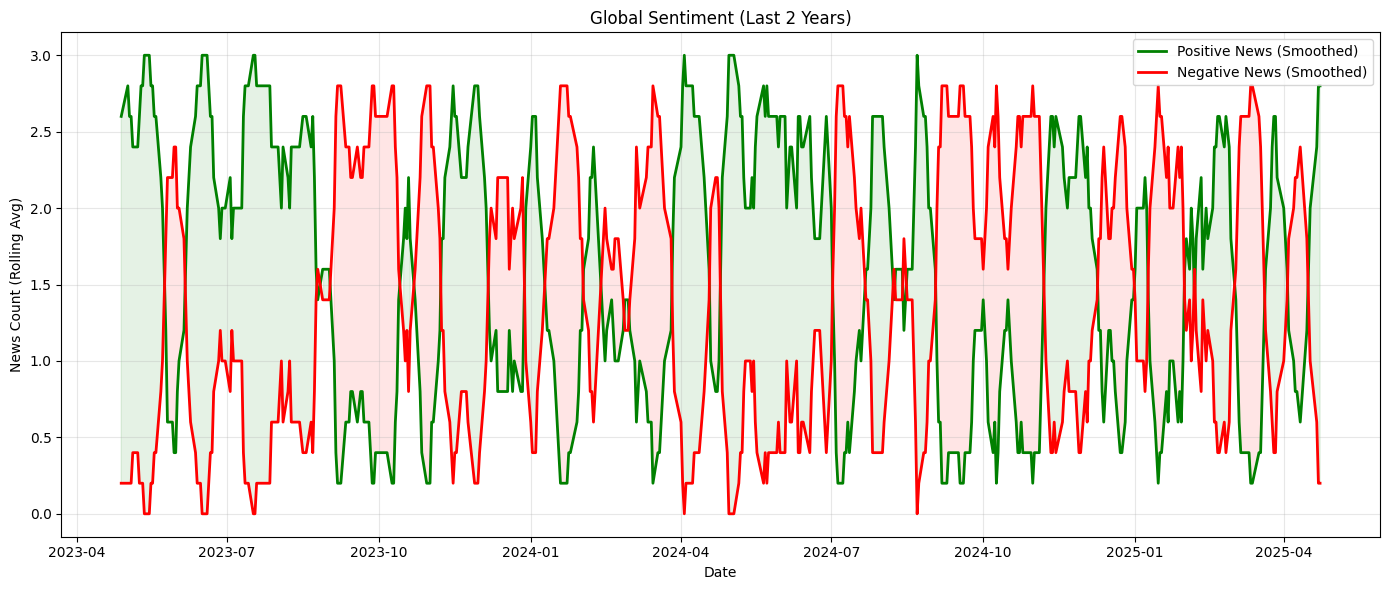

In [ ]:

plot_sentiment(data)

The selected period seems to be more relevant for analysis, as it's more likely to drive the stock performance with the impact of other external factors.

## 5. STORE FILTERED DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Prepare data file location

data_file_location = "/content/drive/MyDrive/Colab_Notebooks/"
if not os.path.exists(data_file_location):
    os.makedirs(data_file_location)
    print(f"Created directory: {data_file_location}")
else:
    print(f"Directory already exists: {data_file_location}")

data_file_name = "AshokLeyland_stock_price_recent"
data_file_ext = "csv"

# Store dataset
data_5years.to_csv(data_file_location + data_file_name + "." + data_file_ext, index=None)

print(f"File saved at: {data_file_location}{data_file_name}.{data_file_ext}")

Directory already exists: /content/drive/MyDrive/Colab_Notebooks/
File saved at: /content/drive/MyDrive/Colab_Notebooks/AshokLeyland_stock_price_recent.csv


In [ ]:
data_5years.tail()

,Date,Adj_Close,Close,High,Low,Open,Volume,20MA,50MA,200MA,...,Price_to_MA_20,Price_to_MA_50,Price_to_MA_200,Trend_Strength,Global_Positive_Count,Global_Negative_Count,Global_Sentiment,Global_Lead,Global_Signal,MA_Combined_Signal
1233,2025-04-16,214.399994,214.399994,215.500000,212.869995,214.699997,4834906,207.303500,210.694201,224.414008,...,0.034232,0.017588,-0.044623,-2,2,1,1,3.0,1,-0.75
1234,2025-04-17,218.979996,218.979996,219.399994,212.830002,214.289993,6372845,208.329499,210.737201,224.309103,...,0.051123,0.039114,-0.023758,-2,3,0,3,1.0,1,-0.75
1235,2025-04-21,222.059998,222.059998,223.100006,218.160004,219.440002,5302390,209.509499,211.051400,224.220936,...,0.059904,0.052161,-0.009638,-2,3,0,3,3.0,1,-0.75
1236,2025-04-22,222.669998,222.669998,225.339996,220.910004,222.000000,5057422,210.358498,211.426600,224.151227,...,0.058526,0.053179,-0.006608,-1,3,0,3,3.0,1,-0.25
1237,2025-04-23,225.100006,225.100006,228.279999,223.000000,224.000000,4603212,211.239499,211.695201,224.114775,...,0.065615,0.063321,0.004396,-1,3,0,3,3.0,1,0.00
